<a href="https://colab.research.google.com/github/Arthur-ca/MIE1517/blob/Jing-Guo/ExtractFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import torchvision
from torchvision import datasets, models
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F1
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder
import tensorflow as tf
import gc
from collections import Counter
import imgaug.augmenters as iaa
import cv2
import dlib
from collections import defaultdict
from matplotlib import pyplot as plt

In [2]:
#First link it to google drive and check the subfolder of the data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
classeses = []
for i in os.listdir('/content/gdrive/MyDrive/MIE1517/Hands/archive'):
    if i!=5:
        classeses.append(i)
classeses

['contempt',
 'neutrality',
 'sadness',
 'disgust',
 'fear',
 'anger',
 'happiness',
 'surprise']

install pre-trained model DLIB

In [4]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2023-11-30 17:18:31--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  69.0MB/s    in 0.9s    

2023-11-30 17:18:32 (69.0 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



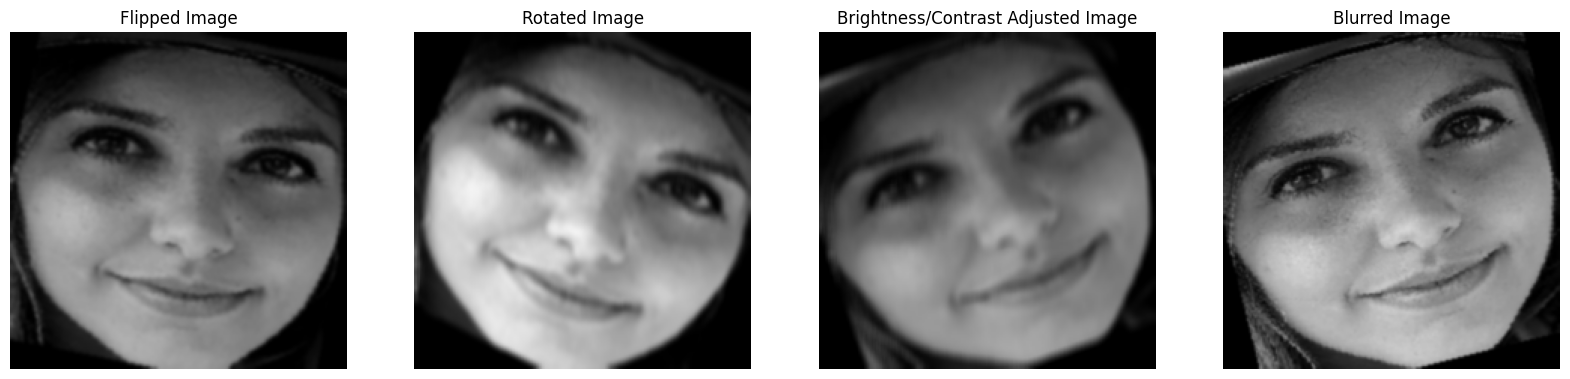

In [26]:
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import io

# Load the image from file
img_path = '/content/20958741469_767244862f_b_face.png'
image = Image.open(img_path).convert('RGB')

# Define the augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # Flip with a probability of 1 (always flip)
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
])

# Apply transformations
flipped_img = augmentation_transforms(image)
rotated_img = augmentation_transforms(image)
bright_img = augmentation_transforms(image)
blurred_img = augmentation_transforms(image)

# Plot the images
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(flipped_img)
ax[0].set_title('Flipped Image')
ax[0].axis('off')

ax[1].imshow(rotated_img)
ax[1].set_title('Rotated Image')
ax[1].axis('off')

ax[2].imshow(bright_img)
ax[2].set_title('Brightness/Contrast Adjusted Image')
ax[2].axis('off')

ax[3].imshow(blurred_img)
ax[3].set_title('Blurred Image')
ax[3].axis('off')

plt.show()

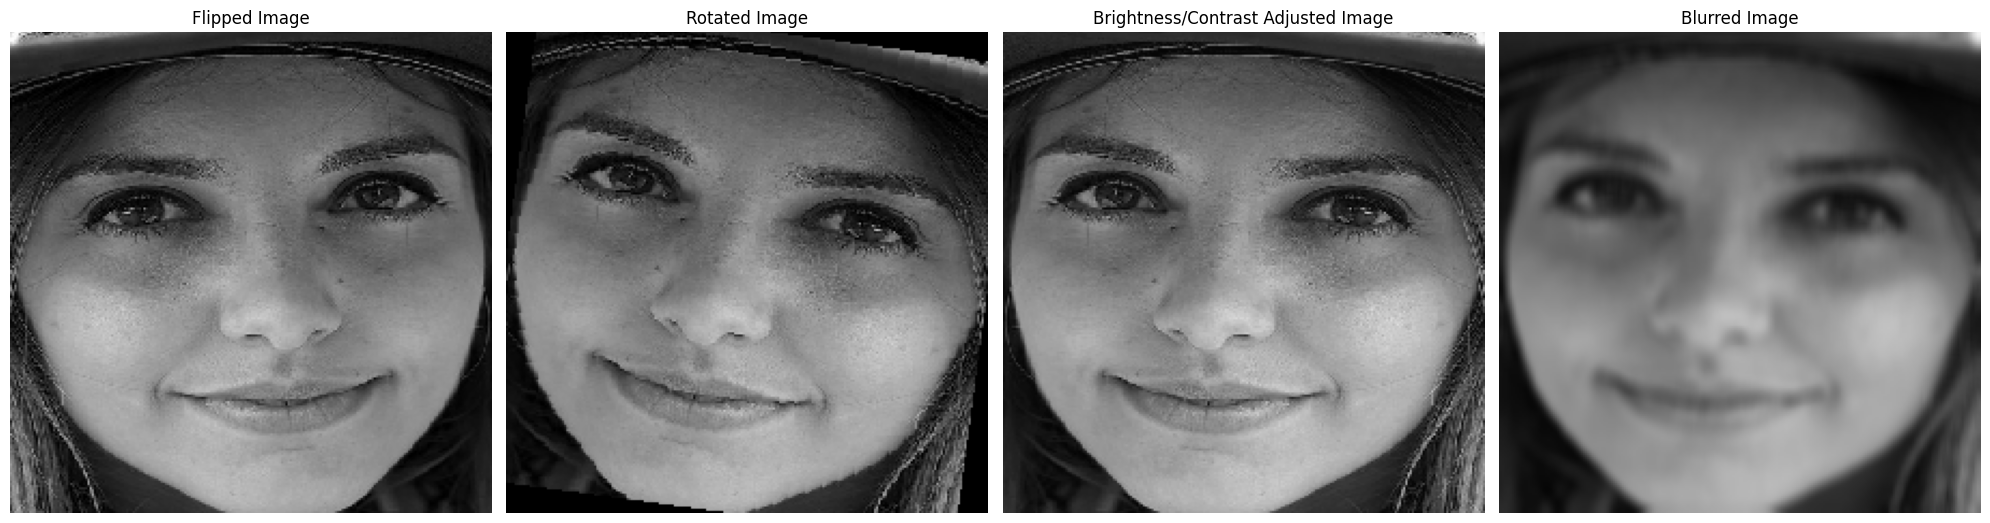

In [27]:

# Load the image from file
image = Image.open('/content/20958741469_767244862f_b_face.png').convert('RGB')

# Define separate transformations
flip_transform = transforms.RandomHorizontalFlip(p=1)  # Flip with a probability of 1 (always flip)
rotate_transform = transforms.RandomRotation(30)
color_jitter_transform = transforms.ColorJitter(brightness=0.3, contrast=0.3)
blur_transform = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))

# Apply transformations
flipped_img = flip_transform(image)
rotated_img = rotate_transform(image)
bright_img = color_jitter_transform(image)
blurred_img = blur_transform(image)

# Convert to numpy arrays for consistent matplotlib display
flipped_img_np = np.array(flipped_img)
rotated_img_np = np.array(rotated_img)
bright_img_np = np.array(bright_img)
blurred_img_np = np.array(blurred_img)

# Plot the images
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(flipped_img_np)
ax[0].set_title('Flipped Image')
ax[0].axis('off')

ax[1].imshow(rotated_img_np)
ax[1].set_title('Rotated Image')
ax[1].axis('off')

ax[2].imshow(bright_img_np)
ax[2].set_title('Brightness/Contrast Adjusted Image')
ax[2].axis('off')

ax[3].imshow(blurred_img_np)
ax[3].set_title('Blurred Image')
ax[3].axis('off')

plt.tight_layout()
plt.show()

In [14]:
import os
from torchvision import transforms
from PIL import Image
from collections import Counter

# Define the path to your dataset
data_dir = '/content/gdrive/MyDrive/MIE1517/Hands/archive'

# Define the augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # Flip with a probability of 1 (always flip)
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
])

# Function to count images in each directory
def count_images(data_dir):
    counts = Counter()
    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            counts[class_dir] = len(os.listdir(class_path))
    return counts

# Function to augment images to match the max count
def augment_to_match_max(data_dir, max_count):
    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)
        image_files = os.listdir(class_path)
        num_images = len(image_files)
        num_to_augment = max_count - num_images

        for i in range(num_to_augment):
            img_path = os.path.join(class_path, image_files[i % num_images])
            img = Image.open(img_path).convert("RGB")
            augmented_img = augmentation_transforms(img)
            augmented_img_path = os.path.join(class_path, f"aug_{i}_{image_files[i % num_images]}")
            augmented_img.save(augmented_img_path)

# Get the count of images in each class
counts = count_images(data_dir)
max_count = max(counts.values())

# Augment images in each class directory
augment_to_match_max(data_dir, max_count)

In [15]:
def count_images_in_directories(directory):
    """
    Counts the number of image files in each subdirectory of the given directory.

    :param directory: Path to the main directory that contains subdirectories for each label/class.
    :return: A dictionary with keys as labels/classes and values as the count of images.
    """
    label_counts = {}
    # Iterate over each subdirectory in the main directory
    for label in os.listdir(directory):
        sub_dir = os.path.join(directory, label)
        # Make sure the subdirectory is indeed a directory
        if os.path.isdir(sub_dir):
            # List all files in the subdirectory and count them
            label_counts[label] = len([f for f in os.listdir(sub_dir) if os.path.isfile(os.path.join(sub_dir, f))])
    return label_counts

#  'data_dir' is the main directory containing subdirectories for each label/class
data_dir = '/content/gdrive/MyDrive/MIE1517/Hands/archive'

# Get the image counts after augmentation
label_image_counts_after_augmentation = count_images_in_directories(data_dir)


In [16]:
label_image_counts_after_augmentation

{'contempt': 1406,
 'neutrality': 1406,
 'sadness': 1406,
 'disgust': 1406,
 'fear': 1406,
 'anger': 1406,
 'happiness': 1406,
 'surprise': 1406}

In [ ]:
'''import cv2
import dlib
import os
import numpy as np
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from torchvision import transforms

# Initialize Dlib's face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')

# Define transformations
flip_transform = transforms.RandomHorizontalFlip(p=1)  # Always flip
rotate_transform = transforms.RandomRotation(30)
color_jitter_transform = transforms.ColorJitter(brightness=0.3, contrast=0.3)
blur_transform = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))

# Function to apply transformations and save images
def augment_and_save_images(image_path, save_dir, label, label_counts, max_count):

    image_pil = Image.open(image_path).convert('RGB')
    augmented_images = []

    while label_counts[label] < max_count:
        for transform, suffix in [(flip_transform, '_flipped'), (rotate_transform, '_rotated'),
                                  (color_jitter_transform, '_jittered'), (blur_transform, '_blurred')]:
            transformed_img = transform(image_pil)
            aug_img_path = os.path.join(save_dir, label, f"{Path(image_path).stem}{suffix}.jpg")
            os.makedirs(os.path.dirname(aug_img_path), exist_ok=True)
            transformed_img.save(aug_img_path)
            augmented_images.append(aug_img_path)
            label_counts[label] += 1
            if label_counts[label] >= max_count:
                break
    return augmented_images
# Function to extract and combine eyes, eyebrows, and mouth into a single image
def extract_and_combine_regions(gray, landmarks):
    # Create masks for eyes including eyebrows and mouth
    mask_eyes_eyebrows = np.zeros_like(gray)
    mask_mouth = np.zeros_like(gray)

    # Points for eyes and eyebrows
    eyes_eyebrows_points = np.concatenate([
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 27)]),  # Eyebrows
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 48)])   # Eyes
    ])

    # Points for mouth
    mouth_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])  # Mouth

    # Fill the masks with the polygons defined by points
    cv2.fillPoly(mask_eyes_eyebrows, [eyes_eyebrows_points], 255)
    cv2.fillPoly(mask_mouth, [mouth_points], 255)

    # Use the masks to extract the regions from the image
    eyes_eyebrows_region = cv2.bitwise_and(gray, mask_eyes_eyebrows)
    mouth_region = cv2.bitwise_and(gray, mask_mouth)

    # Combine the regions on a black background
    combined_image = np.zeros_like(gray)
    combined_image[mask_eyes_eyebrows == 255] = eyes_eyebrows_region[mask_eyes_eyebrows == 255]
    combined_image[mask_mouth == 255] = mouth_region[mask_mouth == 255]

    return combined_image

def process_dataset(dataset_dir, save_dir):
    # Load all image paths from the dataset directory
    all_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(dataset_dir) for f in filenames]

    # Count the number of images per label to determine max count for augmentation
    label_counts = Counter([os.path.basename(os.path.dirname(p)) for p in all_images])
    max_count = max(label_counts.values())

    # Split dataset into training, validation, and test sets
    train_val, test = train_test_split(all_images, test_size=0.2, random_state=0)
    train, val = train_test_split(train_val, test_size=0.25, random_state=0)

    # Initialize lists to store features, labels, and failed indices
    features, labels, failed_indices = [], [], []

    for label in classeses:

        os.makedirs(os.path.join(save_dir, label), exist_ok=True)
    # Process images from training and validation sets
    for img_path in train + val:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Apply CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray_clahe = clahe.apply(img)

        # Detect faces in the image
        faces = detector(gray_clahe, 1)

        # If no faces are detected with CLAHE, try standard histogram equalization
        if not faces:
            gray_eq = cv2.equalizeHist(img)
            faces = detector(gray_eq, 1)
            gray_clahe = gray_eq if faces else gray_clahe

        if faces:
            # Extract facial features and combine them
            landmarks = predictor(gray_clahe, faces[0])
            combined_img = extract_and_combine_regions(gray_clahe, landmarks)

            # Save the original and combined images
            label = os.path.basename(os.path.dirname(img_path))
            base_name = Path(img_path).stem
            original_img_path = os.path.join(save_dir, label, f'{base_name}.jpg')
            combined_img_path = os.path.join(save_dir, label, f'{base_name}_combined.jpg')
            cv2.imwrite(original_img_path, gray_clahe)
            cv2.imwrite(combined_img_path, combined_img)

            # Augment and save images
            augmented_paths = augment_and_save_images(original_img_path, save_dir, label, label_counts, max_count)
            for aug_path in augmented_paths:
                features.append(aug_path)
                labels.append(label)
'''
            for aug_path in augmented_paths:
              if aug_path in train:
                  train_features.append(combined_img)
                  train_labels.append(label)
              else:
                  val_features.append(combined_img)
                  val_labels.append(label)
'''
            # Add combined image and label to lists
            features.append(combined_img_path)
            labels.append(label)
        else:
            # Record failed indices for images where faces were not detected
            failed_indices.append(img_path)

    # Process test dataset without augmentation or feature extraction
    for img_path in test:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            test_img_path = os.path.join(save_dir, 'test', Path(img_path).name)
            cv2.imwrite(test_img_path, img)

    # Return the lists of features, labels, and failed indices
    return features, labels, failed_indices

# Usage
features, labels, failed_indices = process_dataset(
    dataset_dir='/content/gdrive/MyDrive/MIE1517/Hands/archive',
    save_dir='/content/processed_dataset'
)

# Print the label counts and failed indices
label_counts = Counter(labels)
for label, count in label_counts.items():
    print(f"Label {label}: {count} images")

FileNotFoundError: ignored

In [ ]:
'''# Initialize Dlib's face detector (HOG-based) and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')

# Function to extract and combine eyes, eyebrows, and mouth into a single image
def extract_and_combine_regions(gray, landmarks):
    # Create masks for eyes including eyebrows and mouth
    mask_eyes_eyebrows = np.zeros_like(gray)
    mask_mouth = np.zeros_like(gray)

    # Points for eyes and eyebrows
    eyes_eyebrows_points = np.concatenate([
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 27)]),  # Eyebrows
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 48)])   # Eyes
    ])

    # Points for mouth
    mouth_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])  # Mouth

    # Fill the masks with the polygons defined by points
    cv2.fillPoly(mask_eyes_eyebrows, [eyes_eyebrows_points], 255)
    cv2.fillPoly(mask_mouth, [mouth_points], 255)

    # Use the masks to extract the regions from the image
    eyes_eyebrows_region = cv2.bitwise_and(gray, mask_eyes_eyebrows)
    mouth_region = cv2.bitwise_and(gray, mask_mouth)

    # Combine the regions on a black background
    combined_image = np.zeros_like(gray)
    combined_image[mask_eyes_eyebrows == 255] = eyes_eyebrows_region[mask_eyes_eyebrows == 255]
    combined_image[mask_mouth == 255] = mouth_region[mask_mouth == 255]

    return combined_image
def create_images_and_save(directory, save_originals_dir, save_combined_dir):
    features = []
    labels= []

    failed_indices = []

    # Create subdirectories for each label in both save directories
    for label in classeses:
        os.makedirs(os.path.join(save_originals_dir, label), exist_ok=True)
        os.makedirs(os.path.join(save_combined_dir, label), exist_ok=True)

    for i, photo in enumerate(classeses):
        path = os.path.join(directory, photo)
        label = photo  # Use the name of the folder as the label

        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            # Convert the image to grayscale and apply CLAHE
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Apply CLAHE to improve the contrast locally
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            gray_clahe = clahe.apply(gray)

            # Detect faces in the CLAHE preprocessed image
            faces = detector(gray_clahe, 1)
            # If no faces are detected with CLAHE, try standard histogram equalization
            if len(faces) == 0:
                gray_eq = cv2.equalizeHist(gray)
                faces = detector(gray_eq, 1)
                image_to_use = gray_eq
            else:
                image_to_use = gray_clahe

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(image_to_use, face)
                combined_region = extract_and_combine_regions(image_to_use, landmarks)

                # Define paths for saving images
                original_img_path = os.path.join(save_originals_dir, label, img_name)
                combined_img_path = os.path.join(save_combined_dir, label, img_name)

                # Save the original and combined images
                cv2.imwrite(original_img_path, img)  # Save original image
                cv2.imwrite(combined_img_path, combined_region)  # Save combined image

                # Append the combined image and its label to the list
                features.append(combined_region)
                labels.append(i)  # We use the index for the label here
            else:
                failed_indices.append(i)

    return features_or, labels_or, failed_indices

# Call the function with updated paths
dataset_directory = '/content/gdrive/MyDrive/MIE1517/Hands/archive'
save_originals_directory = '/content/saved_original'
save_combined_directory = '/content/saved_combine'

features, labels, failed_indices = create_images_and_save(
    dataset_directory,
    save_originals_directory,
    save_combined_directory
)

# Print the label counts and failed indices
label_counts = Counter(labels)
for label, count in label_counts_or.items():
    print(f"Label {label}: {count} images")

Label 0: 142 images
Label 1: 419 images
Label 2: 448 images
Label 3: 292 images
Label 4: 372 images
Label 5: 585 images
Label 6: 896 images
Label 7: 600 images


In [17]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
import cv2
import dlib
import numpy as np
import os
from pathlib import Path

# Initialize Dlib's face detector (HOG-based) and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')


# Function to extract and combine eyes, eyebrows, and mouth into a single image
def extract_and_combine_regions(gray, landmarks):
    # Create masks for eyes including eyebrows and mouth
    mask_eyes_eyebrows = np.zeros_like(gray)
    mask_mouth = np.zeros_like(gray)

    # Points for eyes and eyebrows
    eyes_eyebrows_points = np.concatenate([
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 27)]),  # Eyebrows
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 48)])   # Eyes
    ])

    # Points for mouth
    mouth_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])  # Mouth

    # Fill the masks with the polygons defined by points
    cv2.fillPoly(mask_eyes_eyebrows, [eyes_eyebrows_points], 255)
    cv2.fillPoly(mask_mouth, [mouth_points], 255)

    # Use the masks to extract the regions from the image
    eyes_eyebrows_region = cv2.bitwise_and(gray, mask_eyes_eyebrows)
    mouth_region = cv2.bitwise_and(gray, mask_mouth)

    # Combine the regions on a black background
    combined_image = np.zeros_like(gray)
    combined_image[mask_eyes_eyebrows == 255] = eyes_eyebrows_region[mask_eyes_eyebrows == 255]
    combined_image[mask_mouth == 255] = mouth_region[mask_mouth == 255]

    return combined_image

def split_process_dataset(dataset_dir, save_originals_dir, save_combined_dir):
    all_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(dataset_dir) for f in filenames]
    train_val, test_paths = train_test_split(all_images, test_size=0.2, random_state=42)
    train_paths, val_paths = train_test_split(train_val, test_size=0.25, random_state=42)

    train_features, train_labels, val_features, val_labels, failed_indices = [], [], [], [], []

    # Initialize CLAHE outside the loop
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # Create subdirectories for each label in both save directories
    for label in classeses:
        os.makedirs(os.path.join(save_originals_dir, label), exist_ok=True)
        os.makedirs(os.path.join(save_combined_dir, label), exist_ok=True)
    # Process images
    for img_path in train_paths + val_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)


        gray_clahe = clahe.apply(img)
        faces = detector(gray_clahe, 1)
        if not faces:
            gray_eq = cv2.equalizeHist(img)
            faces = detector(gray_eq, 1)
            gray_clahe = gray_eq if faces else gray_clahe

        if faces:
            face = faces[0]
            landmarks = predictor(gray_clahe, face)
            combined_img = extract_and_combine_regions(gray_clahe, landmarks)

            label = Path(img_path).parent.name
            combined_img_path = os.path.join(save_combined_dir, label, Path(img_path).name)
            cv2.imwrite(combined_img_path, combined_img)

            if img_path in train_paths:
                train_features.append(combined_img)
                train_labels.append(label)
            else:
                val_features.append(combined_img)
                val_labels.append(label)
        else:
            failed_indices.append(img_path)

    # Process test images without modifications
    for img_path in test_paths:
        label = Path(img_path).parent.name
        test_img_path = os.path.join(save_originals_dir, 'test', label, Path(img_path).name)
        cv2.imwrite(test_img_path, img)

    return train_features, train_labels, val_features, val_labels, failed_indices, test_paths

# Preprocess and transform the images
transform = transforms.Compose([transforms.ToTensor()])

# Convert processed images into tensors and apply transforms
def prepare_dataset(images, labels, transform):
    tensor_images = [transform(image) for image in images]
    tensor_labels = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(torch.stack(tensor_images), tensor_labels)

# Main processing
dataset_directory = '/content/gdrive/MyDrive/MIE1517/Hands/archive'
save_originals_directory = '/content/saved_original'
save_combined_directory = '/content/saved_combined'

train_features, train_labels, val_features, val_labels, failed_indices, test_paths = split_process_dataset(
    dataset_directory, save_originals_directory, save_combined_directory
)

In [18]:
train_label_counts = Counter(train_labels)
for label, count in train_label_counts.items():
    print(f"Label {label}: {count} images")

Label happiness: 541 images
Label surprise: 631 images
Label fear: 510 images
Label disgust: 470 images
Label contempt: 499 images
Label sadness: 455 images
Label neutrality: 607 images
Label anger: 519 images


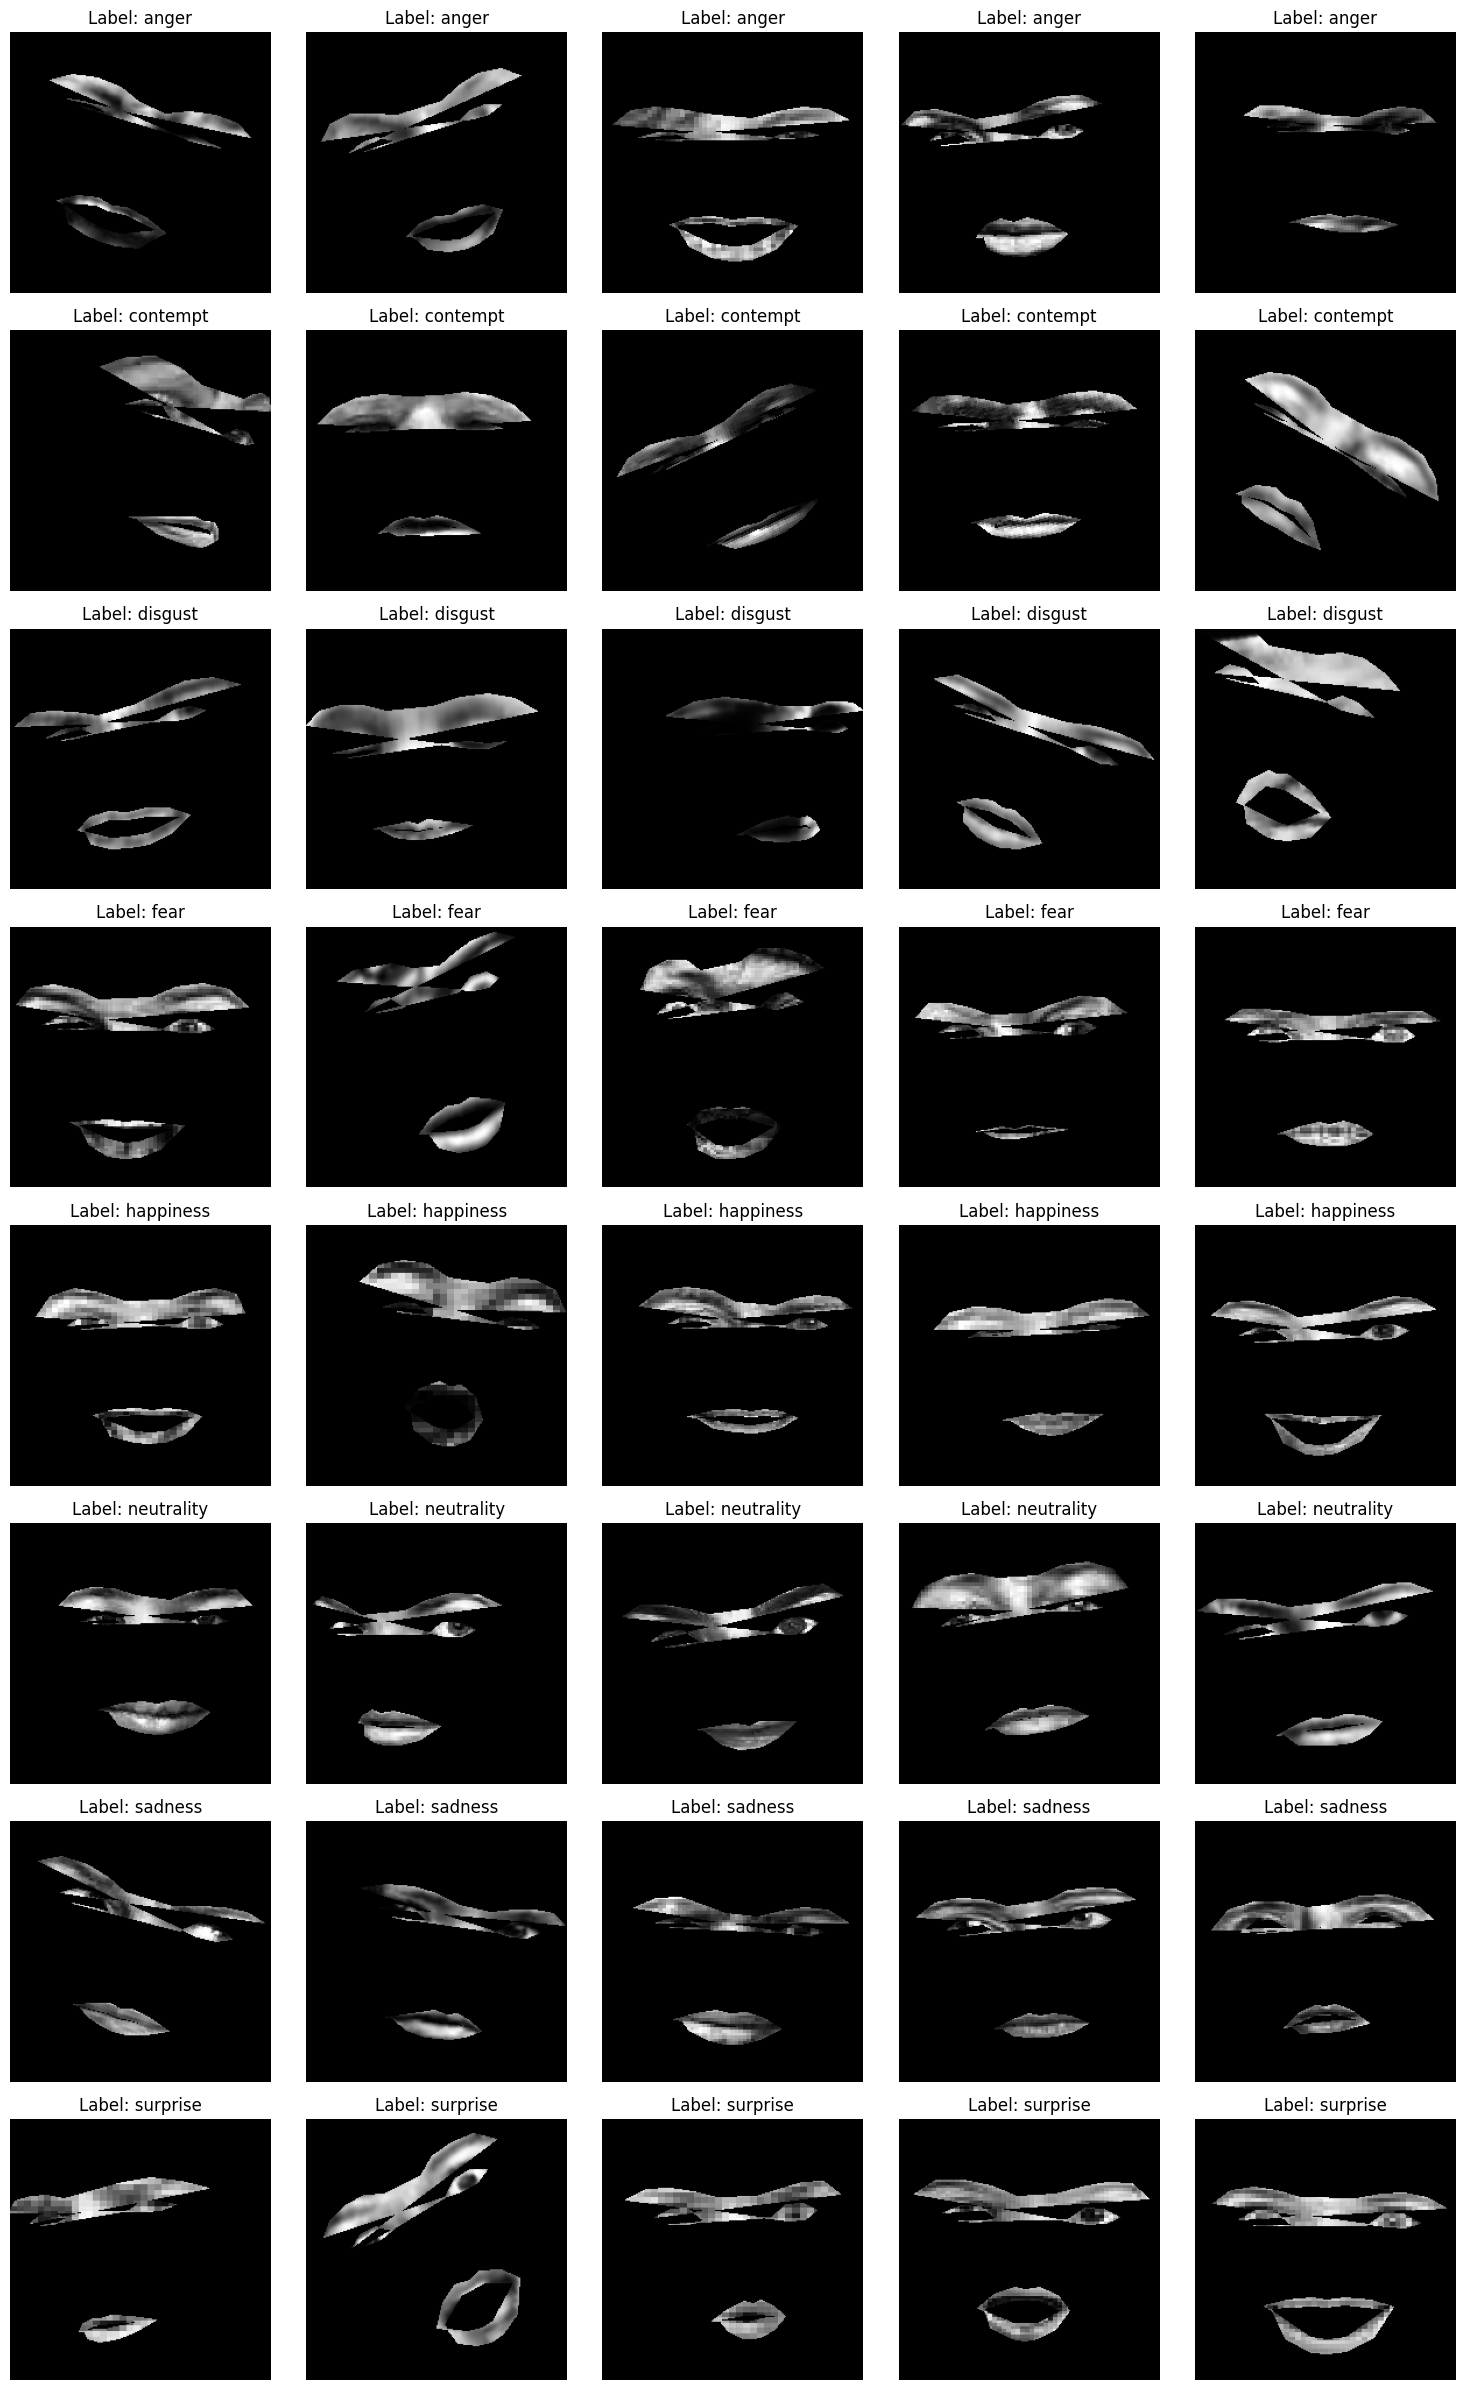

In [22]:
def plot_five_images_per_label(images, labels, class_names):
    # Convert labels to indices if they are not already indices
    label_to_index = {label: idx for idx, label in enumerate(class_names)}
    label_indices = {label: [] for label in class_names}

    # Populate the dictionary with indices of images for each label
    for index, label in enumerate(labels):
        if isinstance(label, str):
            label_index = label_to_index[label]
        else:
            label_index = label
        label_indices[class_names[label_index]].append(index)

    # Initialize the plot
    fig, axes = plt.subplots(len(class_names), 5, figsize=(15, 3 * len(class_names)))

    # Ensure axes is a 2D array
    if len(class_names) == 1:
        axes = [axes]

    # Plot five images for each unique label
    for label_idx, label in enumerate(class_names):
        indices = label_indices[label][:5]  # Get the first 'n' indices for this label
        for img_idx, img_index in enumerate(indices):
            axes[label_idx, img_idx].imshow(images[img_index], cmap='gray')
            axes[label_idx, img_idx].set_title(f'Label: {label}')
            axes[label_idx, img_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with the actual data
plot_five_images_per_label(train_features, train_labels, classes)


In [ ]:
# Prepare datasets for combined regions
train_dataset = prepare_dataset(train_features, train_labels, transform)
val_dataset = prepare_dataset(val_features, val_labels, transform)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CombinedCNN(nn.Module):
    def __init__(self, num_classes):
        super(CombinedCNN, self).__init__()

        # Define convolutional layers using nn.Sequential
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Assuming input channels = 1 (grayscale)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Define fully connected layers using nn.Sequential
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        # Apply convolutional layers
        x = self.conv_layers(x)

        # Flatten the output for the fully connected layers
        x = x.view(-1, 512 * 7 * 7)

        # Apply fully connected layers
        x = self.fc_layers(x)

        return x

num_classes = 8
combined_model = CombinedCNN(num_classes)

Train Region-Specific CNNs (RegionCNN):
Train the RegionCNN models separately for each facial region (eyes, eyebrows, mouth) using the corresponding part of the face images.


In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

def evaluate(model, loader):
    """ Evaluate the network """
    correct = 0
    total = 0

    for inputs, labels in loader:
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()

      outputs = model(inputs)
      predicted = outputs.max(1, keepdim=True)[1]
      total += inputs.shape[0]
      correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return correct / total

In [ ]:
import time
def trainmodel(model, train_dataset, val_dataset, batch=64, learningRate=0.001, num_epochs=300):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)

    model_checkpoint_path = 'D:/MIE1517/output'

    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    train_accuracy = np.zeros(num_epochs)
    train_losses = np.zeros(num_epochs)
    validation_accuracy = np.zeros(num_epochs)
    validation_losses = np.zeros(num_epochs)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()

    print("Training Begin...\n")
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses[epoch] = running_loss / len(train_loader)
        train_accuracy[epoch] = evaluate(model, train_loader)

        model.eval()
        valid_loss = 0.0
        for inputs, labels in val_loader:
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

        validation_losses[epoch] = valid_loss / len(val_loader)
        validation_accuracy[epoch] = evaluate(model, val_loader)

        print(f"Epoch {epoch+1}: Train Acc: {train_accuracy[epoch]:.2f}, Train Loss: {train_losses[epoch]:.4f} | "
              f"Val Acc: {validation_accuracy[epoch]:.2f}, Val Loss: {validation_losses[epoch]:.4f}")

        model_path = get_model_name(model.name, batch, learningRate, epoch)
        model_path = os.path.join(model_checkpoint_path, model_path)
        torch.save(model.state_dict(), f"{model_path}.pt")

    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")

    # Plotting
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.title("Training and Validation Loss")
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(epochs, train_accuracy, label="Train Accuracy")
    plt.plot(epochs, validation_accuracy, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, train_accuracy, validation_losses, validation_accuracy

In [ ]:
Model1 = trainmodel(combined_model, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.01, num_epochs=300)


Training Begin...



NameError: ignored